In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
#from sklearn import datasets
#from sklearn import preprocessing
#from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.utils import plot_model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Activation,
                                     BatchNormalization, Flatten,
                                     Conv2D, MaxPooling2D,
                                     GlobalAveragePooling2D)

import os
import cv2

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 檢查有沒有 GPU

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

assert len(physical_devices) > 0, "Not enough GPU hardware devices available"

tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow.keras.backend as K
K.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


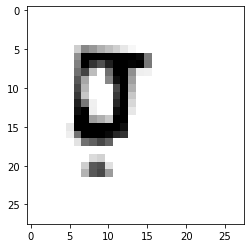

(28, 28)

In [2]:
image = cv2.imread(
    "/home/jovyan/test1/water_aug/0/0000.bmp", 0)
#    "/home/jovyan/at083-group23/aia_meter_datasets/0/20190828101256.bmp", 0)
plt.imshow(image, cmap="gray")
plt.show()
image.shape

In [3]:
image.ndim

2

In [4]:
image.dtype

dtype('uint8')

In [5]:
data_path = "/home/jovyan/test1/water_aug"
#data_path = "/home/jovyan/at083-group23/aia_meter_datasets"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots, each))
            y_data_list.append(roots.split("/")[-1])

In [6]:
#img_size = 224
#img_size = 28

/home/jovyan/test1/water_aug/7/1555.bmp
(28, 28)


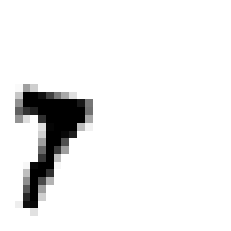

In [7]:
print(x_data_list[0])
img = cv2.imread(x_data_list[0], 0)
#img = cv2.resize(img, (img_size, img_size))
print(img.shape)
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()

In [8]:
#img = img[..., np.newaxis]
print(img.shape)

(28, 28)


In [9]:
def load_img(data_list):
    data_img = []
    for each in tqdm(data_list):
        img = cv2.imread(each, 0)
        #img = cv2.resize(img, (img_size, img_size))
        data_img.append(img[..., np.newaxis])
        #data_img.append(img)

    return np.array(data_img).astype('float32')/255.
#    return np.array(data_img).astype('float32')

In [10]:
x_data = load_img(x_data_list)

100%|██████████| 33240/33240 [00:01<00:00, 29664.79it/s]


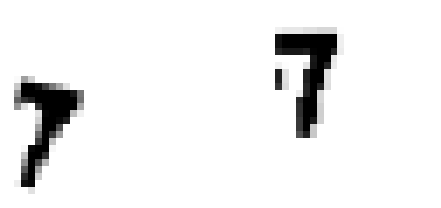

In [11]:
# show image
plt.figure(figsize=(16, 8))
for i in range(2):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_data[i][..., 0], cmap='gray')
    #plt.imshow(x_data[i][:, :, ::-1])
    plt.axis('off')
plt.show()

In [12]:
y_data_list = pd.DataFrame(y_data_list, columns=['label'])
uniques = y_data_list['label'].value_counts().index
counts = y_data_list['label'].value_counts().values
print(uniques)
print('10 + 10 =', uniques.size)

Index(['2', '6', '3', '0', '1', '5', '9', '7', '8', '4', '3-4', '4-5', '9-0',
       '7-8', '0-1', '2-3', '5-6', '8-9', '1-2', '6-7'],
      dtype='object')
10 + 10 = 20


In [13]:
a = pd.DataFrame(uniques.sort_values(), columns=['label'])
print(a.info())
print(a.head(15))

a.to_csv('/home/jovyan/at083-group23/mapping2.txt', float_format=None, 
         columns=['label'], index=True, index_label='idx')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
label    20 non-null object
dtypes: object(1)
memory usage: 288.0+ bytes
None
   label
0      0
1    0-1
2      1
3    1-2
4      2
5    2-3
6      3
7    3-4
8      4
9    4-5
10     5
11   5-6
12     6
13   6-7
14     7


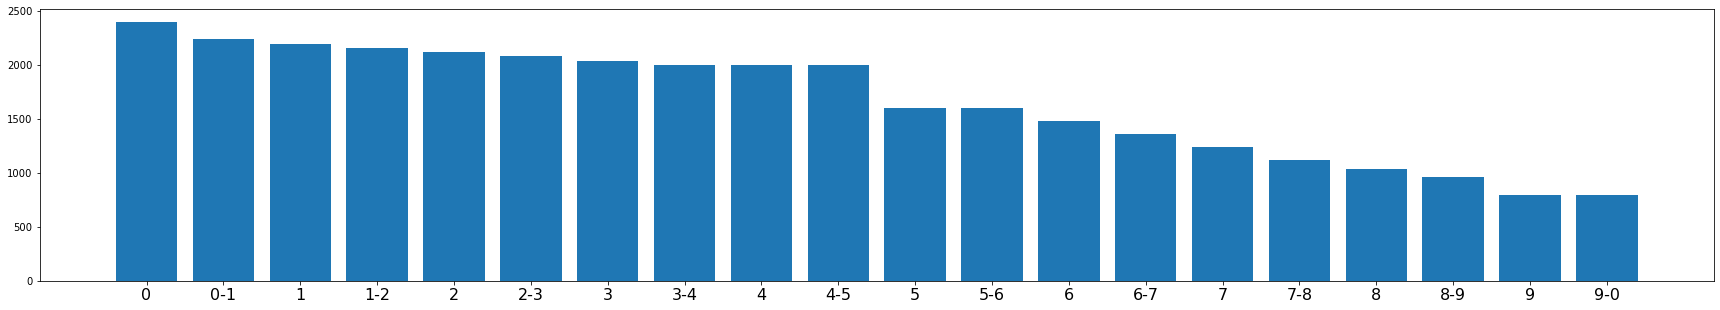

In [14]:
plt.figure(figsize=(30, 5))
plt.bar(uniques.sort_values(), counts)
plt.xticks(fontsize=16)
plt.show()

In [15]:
class_path = "/home/jovyan/at083-group23/"
class_map = pd.read_csv(os.path.join(class_path, 'mapping2.txt'),
                        header=0, names=['label', 'idx'], index_col=['idx'], 
                        usecols=None, dtype=None)
print(class_map.info())
print(class_map.head(15))
class_map = class_map.to_dict()['label']

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 0 to 9-0
Data columns (total 1 columns):
label    20 non-null int64
dtypes: int64(1)
memory usage: 320.0+ bytes
None
     label
idx       
0        0
0-1      1
1        2
1-2      3
2        4
2-3      5
3        6
3-4      7
4        8
4-5      9
5       10
5-6     11
6       12
6-7     13
7       14


In [16]:
class_map

{'0': 0,
 '0-1': 1,
 '1': 2,
 '1-2': 3,
 '2': 4,
 '2-3': 5,
 '3': 6,
 '3-4': 7,
 '4': 8,
 '4-5': 9,
 '5': 10,
 '5-6': 11,
 '6': 12,
 '6-7': 13,
 '7': 14,
 '7-8': 15,
 '8': 16,
 '8-9': 17,
 '9': 18,
 '9-0': 19}

In [17]:
y_data = y_data_list['label'].map(class_map).values.copy()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.1,
                                                    random_state=10,
                                                    stratify=y_data)

In [18]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (29916, 28, 28, 1)
x_test shape: (3324, 28, 28, 1)


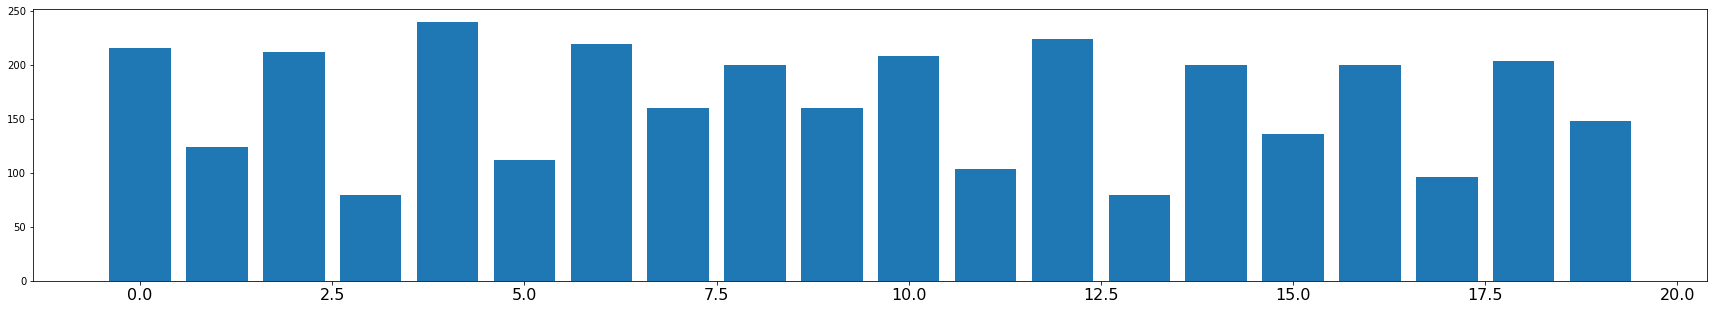

In [19]:
uniques, counts = np.unique(y_test, return_counts=True)
plt.figure(figsize=(30, 5))
plt.bar(uniques, counts)
plt.xticks(fontsize=16)
plt.show()

In [20]:
y_train[0:10]    # 0:10筆的類別

array([ 2, 18,  8, 10, 15, 10, 18, 10,  7, 12])

In [21]:
# 將訓練資料與測試資料的 label，進行 Onehot encoding 轉換
num_classes = len(uniques)

y_train = np.eye(num_classes, dtype='float32')[y_train]
y_test = np.eye(num_classes, dtype='float32')[y_test]

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (29916, 20)
y_test shape: (3324, 20)


In [22]:
# 選擇 Keras 的 API 寫法 -- CNN

#initial = initializers.he_normal()
initial = 'glorot_uniform'


inputs = Input(shape=x_train.shape[1:])
#inputs = Input(shape=(img_size, img_size, 1))

# 第一層
# 建立卷積層，設定32個3*3的filters
# 設定ReLU為激活函數。
x = Conv2D(32, (3, 3), padding='same', kernel_initializer=initial)(inputs)
#x = BatchNormalization()(x)
x = Activation('relu')(x)


# 第二層 - 卷積層 + 池化層
x = Conv2D(32, (3, 3), padding='same', kernel_initializer=initial)(x)
#x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

# 建立分類模型 (MLP) : 平坦層 + 輸出層 (10)
x = Flatten()(x)
#x = GlobalAveragePooling2D()(x)
x = Dense(8, activation='relu')(x)
#x = Dropout(0.25)(x)

outputs = Dense(num_classes, activation='softmax')(x)


cnn_model = Model(inputs=inputs, outputs=outputs)

In [23]:
print(cnn_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0     

In [24]:
model_dir = 'cnn_model-logs-w'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model', cnn_model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model-w.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [25]:
# 編譯模型
# 選用 Adam 為 optimizer
learning_rate = 1e-3
optimizer = keras.optimizers.Adam(lr=learning_rate)



cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [26]:

batch_size = 32
epochs = 300

num_step = x_train.shape[0] // batch_size + 1


In [27]:


datagen = ImageDataGenerator(
                             rotation_range=0,
                             width_shift_range=0,
                             height_shift_range=0,
                             brightness_range=None,
                             shear_range=0.0,
                             zoom_range=0.0,
                             channel_shift_range=0.0,
                             fill_mode='nearest',
                             cval=0.0,
                             horizontal_flip=False,
                             vertical_flip=False,
    
                             )



In [44]:

cnn_history = cnn_model.fit_generator(datagen.flow(x_train, y_train,
                                                batch_size=batch_size),
                                        steps_per_epoch=num_step,
                                        epochs=epochs,
                                        validation_data=(x_test, y_test),
                                        verbose=2,
                                        callbacks=callbacks_list)


Epoch 1/300
935/935 - 18s - loss: 0.0589 - accuracy: 0.9792 - val_loss: 0.3148 - val_accuracy: 0.9224
Epoch 2/300
935/935 - 21s - loss: 0.0514 - accuracy: 0.9813 - val_loss: 0.3064 - val_accuracy: 0.9212
Epoch 3/300
935/935 - 21s - loss: 0.0584 - accuracy: 0.9789 - val_loss: 0.3511 - val_accuracy: 0.9082
Epoch 4/300
935/935 - 21s - loss: 0.0493 - accuracy: 0.9814 - val_loss: 0.3504 - val_accuracy: 0.9125
Epoch 5/300
935/935 - 21s - loss: 0.0507 - accuracy: 0.9818 - val_loss: 0.3014 - val_accuracy: 0.9278
Epoch 6/300
935/935 - 21s - loss: 0.0499 - accuracy: 0.9813 - val_loss: 0.3538 - val_accuracy: 0.9128
Epoch 7/300
935/935 - 21s - loss: 0.0428 - accuracy: 0.9845 - val_loss: 0.3033 - val_accuracy: 0.9254
Epoch 8/300
935/935 - 21s - loss: 0.0433 - accuracy: 0.9849 - val_loss: 0.3608 - val_accuracy: 0.9197
Epoch 9/300
935/935 - 21s - loss: 0.0415 - accuracy: 0.9848 - val_loss: 0.3297 - val_accuracy: 0.9227
Epoch 10/300
935/935 - 21s - loss: 0.0451 - accuracy: 0.9835 - val_loss: 0.3156 - 

In [45]:
best_model = "./cnn_model-logs-w/basic_model-best-model-w.h5"
cnn_model = load_model(best_model)

In [46]:
loss, acc = cnn_model.evaluate(x_test, y_test, verbose=2)

3324/1 - 0s - loss: 0.2733 - accuracy: 0.9287


In [47]:
y_pred = cnn_model.predict(x_test)
print(y_pred[:3])
y_pred = y_pred.argmax(-1)
print(y_pred[:3])

[[6.4675621e-34 5.9641846e-17 0.0000000e+00 1.0091772e-30 1.6672004e-11
  2.7476564e-05 1.4324244e-19 3.9477567e-18 2.3277116e-38 1.5287464e-17
  9.9997246e-01 2.3552655e-09 1.3505986e-07 9.3700776e-11 1.8834858e-38
  1.1050301e-21 1.4145229e-17 3.2775669e-17 1.4513335e-20 4.4399542e-33]
 [1.9543729e-07 8.2155225e-09 6.4609790e-10 5.9026887e-04 5.0078951e-15
  2.8496068e-29 9.9940932e-01 6.0796381e-08 1.3867521e-25 4.3418144e-23
  6.4058686e-26 1.2265658e-19 2.2221468e-30 5.9418852e-08 4.2935600e-10
  6.1679120e-09 3.9877888e-14 3.3306039e-27 2.0045143e-09 2.5328077e-13]
 [1.2005413e-17 1.7844075e-11 1.7960665e-28 4.9351150e-27 0.0000000e+00
  1.6710602e-30 3.0259757e-14 3.5735927e-14 0.0000000e+00 0.0000000e+00
  2.8995945e-31 6.4296881e-18 2.5626420e-25 4.0843606e-08 1.1950756e-26
  9.0914496e-34 1.7225008e-23 2.0675213e-12 2.5146836e-09 1.0000000e+00]]
[10  6 19]


In [48]:
print(accuracy_score(y_test.argmax(-1), y_pred))
#print(confusion_matrix(y_test.argmax(-1), y_pred))
confusion_matrix(y_test.argmax(-1), y_pred)

0.9287003610108303


array([[206,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   2,   0],
       [  6, 112,   0,   0,   0,   0,   1,   2,   0,   0,   0,   0,   0,
          0,   0,   2,   0,   0,   0,   1],
       [  1,   1, 200,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   1,  64,   7,   0,   1,   0,   0,   2,   0,   0,   0,
          0,   0,   5,   0,   0,   0,   0],
       [  0,   0,   0,   6, 219,  14,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  13,  94,   0,   1,   0,   2,   2,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0, 209,   9,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   1,   0],
       [  0,   3,   0,   0,   1,   2,  13, 140,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0, 197,   0,   0,  

In [49]:
class_names = np.array([each for each in class_map.keys()])

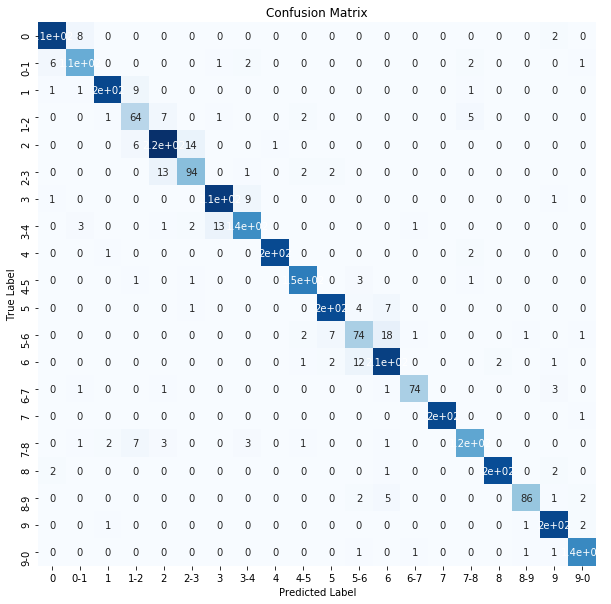

In [50]:
import seaborn as sns

matrix = confusion_matrix(y_test.argmax(-1), y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Save figure first to prevent black after show figure.
plt.savefig('./Confusion Matrix-w.png')

plt.show()